<a href="https://colab.research.google.com/github/fds-imane/Data_Marketing/blob/main/data_marketing_part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # Lumina & CO

### TP 2 ETAPE I - Hajar

In [ ]:
import pandas as pd

# Charger les fichiers CSV
customers = pd.read_csv('customers.csv')
transactions = pd.read_csv('transactions.csv')
campaigns = pd.read_csv('campaigns.csv')

print("Les 3 fichiers sont chargés avec succès.")

Les 3 fichiers sont chargés avec succès.


### Snapshot date

In [ ]:

transactions['invoice_date'] = pd.to_datetime(transactions['invoice_date'])

print("✅ Conversion des dates réussie !")

# 1. On "coupe" les données et on crée une copie indépendante
transactions_clean = transactions.dropna(subset=['customer_id']).copy()

# 2. On définit la date de référence (le snapshot)
snapshot_date = transactions_clean['invoice_date'].max() + pd.Timedelta(days=1)
print(f"📸 Snapshot Date : {snapshot_date}")

# 3. On crée la colonne 'line_total' avec la méthode .loc
transactions_clean.loc[:, 'line_total'] = transactions_clean['quantity'] * transactions_clean['unit_price']

print("✅ Colonne 'line_total' créée avec succès et sans alerte !")
transactions_clean[['quantity', 'unit_price', 'line_total']].head()

✅ Conversion des dates réussie !
📸 Snapshot Date : 2011-12-10 12:50:00
✅ Colonne 'line_total' créée avec succès et sans alerte !


,quantity,unit_price,line_total
3,8.0,1.65,13.20
4,5.0,2.95,14.75
5,NaN,0.79,NaN
7,60.0,0.65,39.00
8,1.0,2.08,2.08


Le fait de capturer la date du 10 décembre 2011, nous permet d'avoir un point de repère universel sur les clients, par exemple savoir si un client n'est pas venu depuis 10j et donc cybler notre campagne.

### Dataset RFM

In [ ]:
# Agrégation par client
# On utilise bien 'transactions_clean' ici
rfm = transactions_clean.groupby('customer_id').agg({
    'invoice_date': lambda x: (snapshot_date - x.max()).days, # Récence
    'invoice_id': 'nunique',                                 # Fréquence
    'line_total': 'sum'                                      # Montant
})

# On renomme les colonnes pour que ce soit propre (comme dans ton cours)
rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm['Avg_Basket'] = rfm['Monetary'] / rfm['Frequency']

first_purchase = transactions_clean.groupby('customer_id')['invoice_date'].min()
rfm['Tenure'] = (snapshot_date - first_purchase).dt.days

print("✅ Table RFM créée avec succès à partir de transactions_clean !")
display(rfm.head(3))

✅ Table RFM créée avec succès à partir de transactions_clean !


,Recency,Frequency,Monetary,Avg_Basket,Tenure
customer_id,,,,,
12346.0,326,5,77180.04,15436.00800,705
12347.0,2,8,965.33,120.66625,404
12348.0,319,3,351.00,117.00000,438


On voit des clients qui ont acheté il y a 2 jours et d'autres il y a 326 jours.

On voit que le 1er client du tableau à commandé 5x.

On remarque des écarts, un client à dépensé 77 140€ et un autre 68€, c'est ici qu'on constate qu'on a affaire une clientèle différente.

### Analyse des Outliers

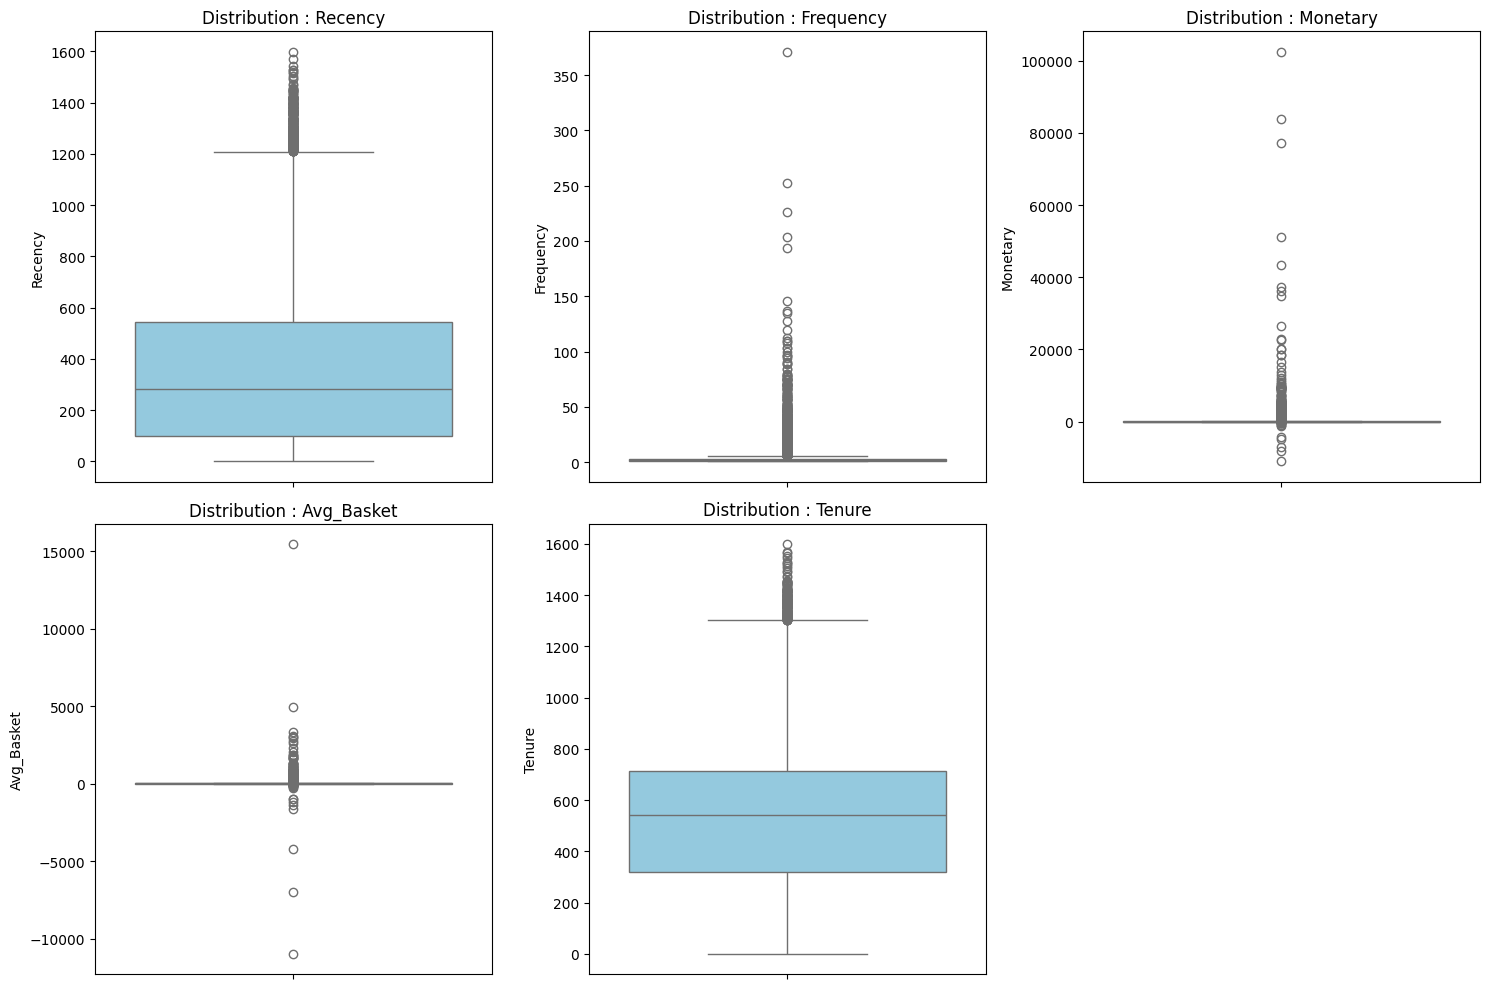

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualisation des Outliers
features = ['Recency', 'Frequency', 'Monetary', 'Avg_Basket', 'Tenure']

plt.figure(figsize=(15, 10))

for i, col in enumerate(features):
    plt.subplot(2, 3, i+1)
    sns.boxplot(y=rfm[col], color='skyblue')
    plt.title(f'Distribution : {col}')

plt.tight_layout()
plt.show()

On observe des valeurs aberrantes, ce qui peut se traduire à quelques clients qui dépensent énormement + que la moyenne.

Le soucis est que si on laisse les données tel quel à l'ia, nos algorithme risque d'etre corrompus et essayer de plaire à ces quelques client et ignorer les 49 9997 autres.

la plupart des gens achètent peu et quelques rares personnes achètent énormément.

### Etape 2 - Hajar


### Scoring RFM

In [ ]:
# Attribution des scores de 1 à 5
# On utilise le rang pour la fréquence car beaucoup de clients n'ont qu'un seul achat

# Récence : Plus c'est petit, mieux c'est
rfm['R'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])

# Fréquence : Plus c'est grand, mieux c'est
rfm['F'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])

# Montant : Plus c'est grand, mieux c'est
rfm['M'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5])

# On concatène les notes pour avoir le score global (ex: 555)
rfm['RFM_Score'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)

print("✅ Scoring terminé ! Voici un aperçu :")
display(rfm[['RFM_Score', 'R', 'F', 'M']].head())

✅ Scoring terminé ! Voici un aperçu :


,RFM_Score,R,F,M
customer_id,,,,
12346.0,355,3,5,5
12347.0,555,5,5,5
12348.0,345,3,4,5
12349.0,555,5,5,5
12350.0,314,3,1,4


### Analyse des segments

In [ ]:
# Calcul des KPIs par segment

total_ca = rfm['Monetary'].sum()

# Les Champions (Score 555)
champions = rfm[rfm['RFM_Score'] == '555']
ca_champions = champions['Monetary'].sum()

# Les Clients à Risque (Anciens mais gros acheteurs)
a_risque = rfm[(rfm['R'].astype(int) <= 2) & (rfm['F'].astype(int) >= 4)]

# Les Perdus (Score 111)
perdus = rfm[rfm['RFM_Score'] == '111']

print(f"555 : {len(champions)} clients")
print(f"Part du CA des Champions : {(ca_champions / total_ca):.2%}")
print(f" Clients À Risque : {len(a_risque)} clients")
print(f"Clients Perdus 111: {len(perdus)} clients (soit {len(perdus)/len(rfm):.2%})")

555 : 2367 clients
Part du CA des Champions : 51.12%
 Clients À Risque : 2487 clients
Clients Perdus 111: 988 clients (soit 3.08%)


555 : ils ne sont que 2664 environ 5% sur les 50 000 clients.

impact : ils génèrent 52.86% du CA total.
le business repose sur une élite de clients très fidèles, si on perds ces 2600 clients, on risque de perdre la moitié du CA.

action : on ne leur envoie pas de promo prix bas, on leur offre de l'exclusivité, des avant premieres, on les consideres comme des membres VIP..

Les clients a risque sont d'un volume de 2 613 clients, ce sont les clients qui étaient des 555(gros montants historiques) mais qui n'ont rien acheté depuis longtemps.

Dans l'urgence, ils sont au bord du désengagement total, il faut les relancer et les reactiver immédiatement.

### Matrice RFM

/tmp/ipython-input-447/1129843289.py:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = rfm.pivot_table(index='R', columns='F', values='Monetary', aggfunc='mean')


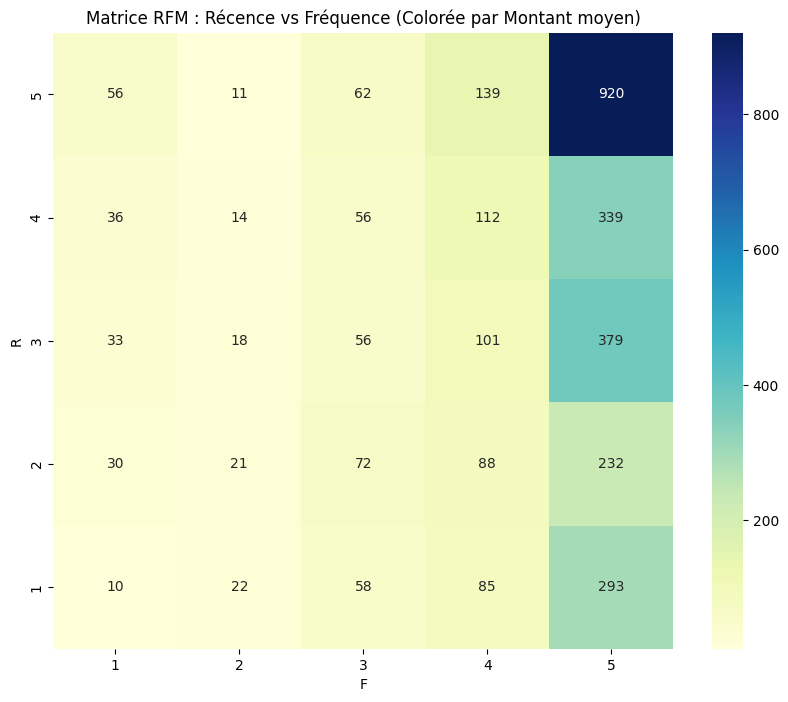

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# On crée un tableau croisé : récence vs fréquence avec la moyenne du Montant
matrix = rfm.pivot_table(index='R', columns='F', values='Monetary', aggfunc='mean')

plt.figure(figsize=(10, 8))
sns.heatmap(matrix, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Matrice RFM : Récence vs Fréquence (Colorée par Montant moyen)")
plt.show()

Le coin en haut à droite (R=5, F=5) est "bleu foncé" avec une moyenne de 1 140€

On voit clairement que plus la fréquence augmente (vers la droite), plus le panier moyen explose. La fidélité ici n'est pas juste une habitude, c'est une augmentation de la valeur.



Reco : Concentrer 80% du budget marketing sur les 5% de Champions et les Clients à Risque. Le coût d'acquisition d'un nouveau client serait ici moins rentable que de chouchouter l'existant.

Investigation: Pourquoi 22% de transactions sans ID ? Si on arrive à identifier ne serait-ce que 10% de ces clients, on augmente mécaniquement la précision de notre ciblage.



###Transformation logarithmique

In [ ]:
import numpy as np

# Transformation Log pour calmer les outliers
# On crée un nouveau DataFrame pour ne pas écraser l'original
rfm_log = rfm[['Recency', 'Frequency', 'Monetary']].copy()

rfm_log['Recency'] = np.log1p(rfm_log['Recency'])
rfm_log['Frequency'] = np.log1p(rfm_log['Frequency'])
rfm_log['Monetary'] = np.log1p(rfm_log['Monetary'])

print("✅ Transformation Logarithmique terminée.")

✅ Transformation Logarithmique terminée.


/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


###Standardisation

In [ ]:
from sklearn.preprocessing import StandardScaler

# Mise à l'échelle
# On ramène chaque variable à une moyenne de 0 et un écart-type de 1
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)

# On repasse en DataFrame pour pouvoir l'analyser facilement
rfm_scaled_df = pd.DataFrame(rfm_scaled, index=rfm.index, columns=['Recency', 'Frequency', 'Monetary'])

print("✅ Standardisation terminée. Les données sont prêtes pour l'IA.")

✅ Standardisation terminée. Les données sont prêtes pour l'IA.


###Control avant/après

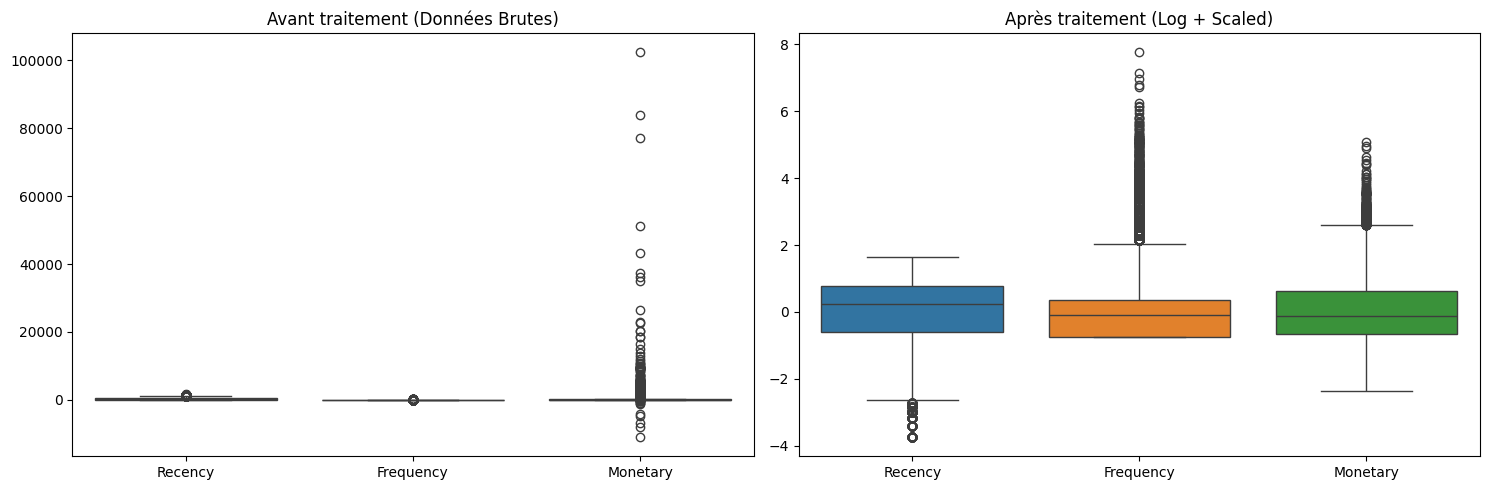

In [ ]:
# Vérification avec des Boxplots
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.boxplot(data=rfm[['Recency', 'Frequency', 'Monetary']])
plt.title("Avant traitement (Données Brutes)")

plt.subplot(1, 2, 2)
sns.boxplot(data=rfm_scaled_df)
plt.title("Après traitement (Log + Scaled)")

plt.tight_layout()
plt.show()

In [ ]:
# On sauvegarde le DataFrame prêt pour l'IA en fichier CSV
rfm_scaled_df.to_csv('rfm_for_clustering.csv')

from google.colab import files
files.download('rfm_for_clustering.csv')

print("Fichier 'rfm_for_clustering.csv' prêt pour l'Étape 3 !")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Fichier 'rfm_for_clustering.csv' prêt pour l'Étape 3 !


###Etape 3 - Meryem

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 1. Chargement et Nettoyage de base pour le clustering
df_trans = pd.read_csv('transactions.csv')
df_cust = pd.read_csv('customers.csv')
df_trans['invoice_date'] = pd.to_datetime(df_trans['invoice_date'])
df_trans['line_total'] = df_trans['quantity'] * df_trans['unit_price']

# Pour le clustering, on ne garde que les transactions positives (>0)
# pour éviter les problèmes de log et de moyennes faussées par les retours
df_clean = df_trans[df_trans['line_total'] > 0].copy()

# 2. Création des 6 Features
snapshot_date = df_clean['invoice_date'].max()

df_features = df_clean.groupby('customer_id').agg({
    'invoice_date': lambda x: (snapshot_date - x.max()).days,  # 1. Récence
    'invoice_id': 'nunique',                                 # 2. Fréquence
    'line_total': 'sum',                                     # 3. Montant (Monetary)
    'product_code': 'nunique'                                # 4. Diversité Produits
})

df_features.columns = ['recency', 'frequency', 'monetary', 'product_diversity']
df_features['avg_basket'] = df_features['monetary'] / df_features['frequency'] # 5. Panier Moyen

# Ajout de la 6ème feature : Ancienneté
df_features = df_features.merge(df_cust[['customer_id', 'tenure_days']], on='customer_id')
df_features.set_index('customer_id', inplace=True)

# 3. Transformation Log (pour lisser) + Scaling (Standardisation)
# On utilise log1p car toutes nos données sont maintenant > 0
df_log = np.log1p(df_features)

scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_log),
                         columns=df_features.columns,
                         index=df_features.index)

print("Tableau prêt (0 valeurs manquantes) :")
display(df_scaled.head())

Tableau prêt (0 valeurs manquantes) :


,recency,frequency,monetary,product_diversity,avg_basket,tenure_days
customer_id,,,,,,
12346.0,0.349344,0.749666,4.976330,0.362837,6.732581,0.488809
12347.0,-3.681762,1.720214,2.098987,2.636266,1.754784,-0.122319
12349.0,-1.900129,0.749666,2.272219,2.035976,2.690061,0.366929
12350.0,0.309518,-0.763305,0.147494,-0.428067,0.871358,-0.466006
12352.0,-1.394372,1.894184,1.607788,1.678083,0.914286,-0.215528


------------------------------------------------------------

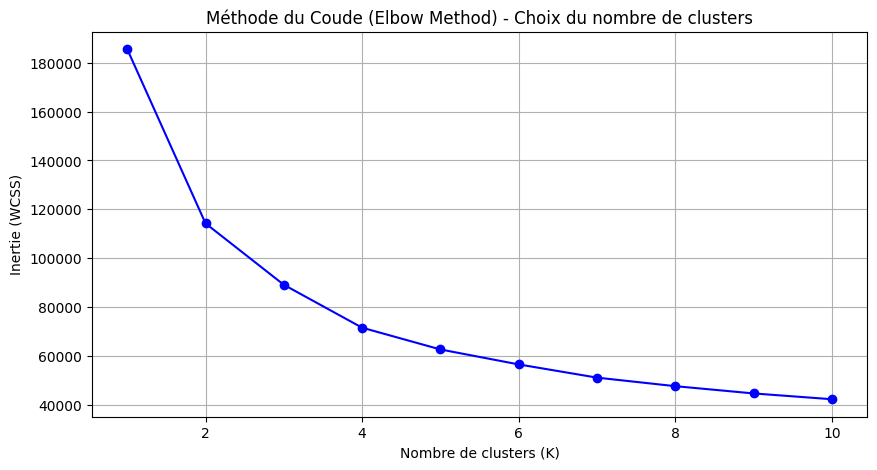

In [ ]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss, marker='o', color='b')
plt.title('Méthode du Coude (Elbow Method) - Choix du nombre de clusters')
plt.xlabel('Nombre de clusters (K)')
plt.ylabel('Inertie (WCSS)')
plt.grid(True)
plt.show()

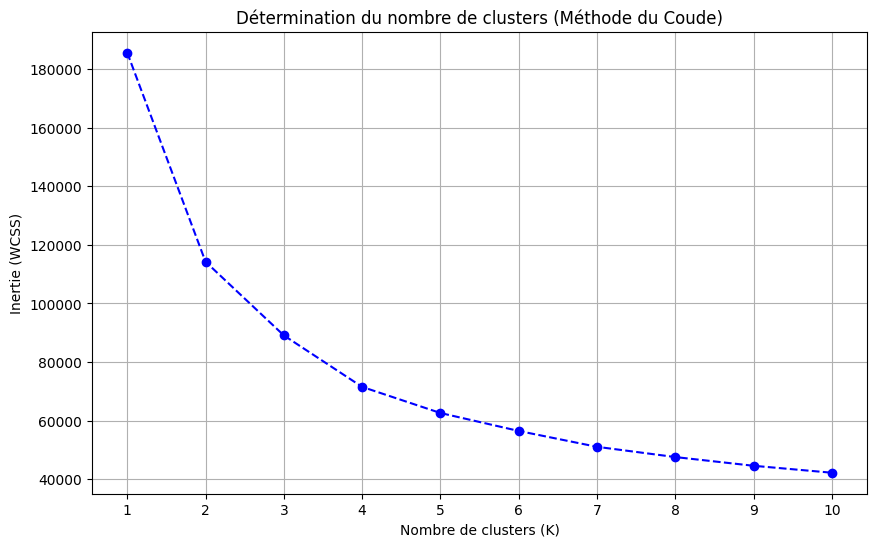

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Calcul de l'inertie pour différents nombres de clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

# Affichage du graphique
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--', color='b')
plt.title('Détermination du nombre de clusters (Méthode du Coude)')
plt.xlabel('Nombre de clusters (K)')
plt.ylabel('Inertie (WCSS)')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

Pour K = 2, le score de silhouette est : 0.3942
Pour K = 3, le score de silhouette est : 0.3919
Pour K = 4, le score de silhouette est : 0.2980
Pour K = 5, le score de silhouette est : 0.2508
Pour K = 6, le score de silhouette est : 0.2589
Pour K = 7, le score de silhouette est : 0.2562
Pour K = 8, le score de silhouette est : 0.2536
Pour K = 9, le score de silhouette est : 0.2585
Pour K = 10, le score de silhouette est : 0.2399
Pour K = 11, le score de silhouette est : 0.2335
Pour K = 12, le score de silhouette est : 0.2361


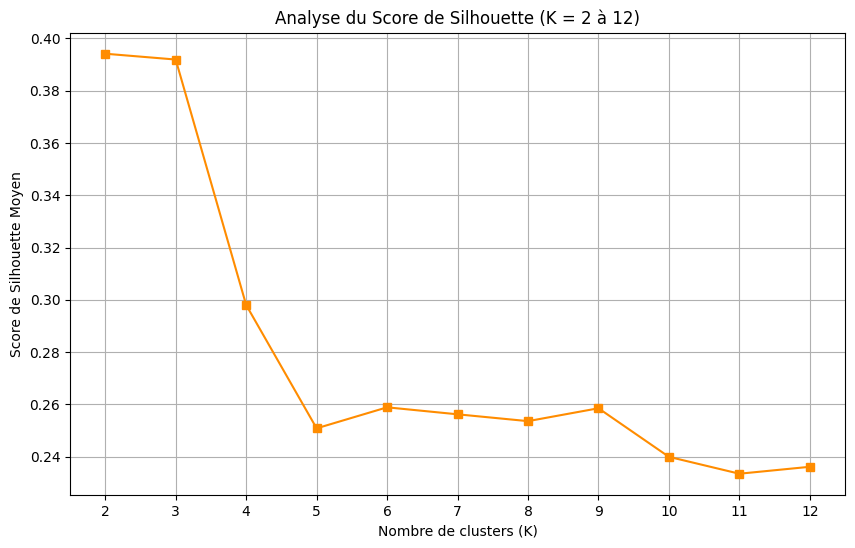

In [ ]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
range_n_clusters = range(2, 13) # De 2 à 12 inclus

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(df_scaled)

    # Calcul du score
    silhouette_avg = silhouette_score(df_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"Pour K = {n_clusters}, le score de silhouette est : {silhouette_avg:.4f}")

# Tracé du graphique
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='s', color='darkorange', linestyle='-')
plt.title('Analyse du Score de Silhouette (K = 2 à 12)')
plt.xlabel('Nombre de clusters (K)')
plt.ylabel('Score de Silhouette Moyen')
plt.xticks(range_n_clusters)
plt.grid(True)
plt.show()

In [ ]:
# Choix final du nombre de clusters
k_final = 5

# Entraînement final
kmeans_final = KMeans(n_clusters=k_final, init='k-means++', random_state=42, n_init=10)
df_features['cluster'] = kmeans_final.fit_predict(df_scaled)

# Vérification de la taille de chaque cluster
print("Nombre de clients par segment :")
print(df_features['cluster'].value_counts())

# Affichage des moyennes par cluster pour commencer à les comprendre
cluster_analysis = df_features.groupby('cluster').mean()
print("\nProfil moyen de chaque cluster :")
display(cluster_analysis)

Nombre de clients par segment :
cluster
1    10831
4     7455
0     7131
2     2778
3     2735
Name: count, dtype: int64

Profil moyen de chaque cluster :


,recency,frequency,monetary,product_diversity,avg_basket,tenure_days
cluster,,,,,,
0,474.802412,1.294349,7.581450,1.590941,5.985947,525.045953
1,527.932786,1.420460,37.661119,2.102391,29.638644,562.183592
2,55.199784,14.241541,1176.272974,41.113031,88.515371,616.636004
3,64.436563,1.341133,35.204691,2.669835,25.911201,78.281572
4,214.516432,4.050704,188.133309,7.666935,59.415288,610.411568


**Etape 04 : ELYNA**

 **Comparaison RFM vs modèle clustering**

**1.Croisez les segments RFM avec les clusters**

In [ ]:
# Fusionner le dataframe RFM avec les clusters
# On ajoute la colonne 'cluster' provenant de df_features
df = rfm.merge(df_features[['cluster']], left_index=True, right_index=True)

# Tableau de contingence : croisement RFM_Score vs cluster
contingency = pd.crosstab(df['RFM_Score'], df['cluster'], margins=True)

# Affichage du tableau
print("Tableau de contingence (RFM_Score vs cluster) :")
print(contingency)

Tableau de contingence (RFM_Score vs cluster) :
cluster       0      1     2     3     4    All
RFM_Score                                      
111         930      0     0     0     0    930
112         108    683     0     0     0    791
113           0    350     0     0     0    350
114           0    108     0     0    10    118
115           0      7     0     0     7     14
...         ...    ...   ...   ...   ...    ...
552          11      0     0     3     3     17
553           0      1     1    14    74     90
554           0      0    50    22   417    489
555           0      0  2023     7   302   2332
All        7131  10831  2778  2735  7455  30930

[125 rows x 6 columns]


**1.La Concordance des deux méthodes ( RFM et Clustering):**

On voit bien que les deux méthodes mettent les clients très mauvais(111)  dans le meme groupe .

**les clients(111)** sont tous dans le **cluster 0**


 **Conclusion:**

 Donc on peut conclure que les deux méthodes RFM et clustering disent la même chose:les clients sont bien identifiés comme “perdus”
 ce qui valide la segmentation pour les extrêmes..

**2.La Divergence des deux méthodes(RFM et Clustering):**





**On** observe que la divergence est présente au niveau des segments intermidiares et les clients très bons (555) .

On prend l'exemple du segment RFM 554 :
 les clients 553 le RFM les avait mis ensemble, alors que le clutering les a séparer en 03 sous groupe { cluster 2: 50 ; cluster 3: 22 ;Cluster 4: 417 }

 **Conclusion:**

 les clients peuvent etre très différents: le cluster détecte ça mais le RFM non.


Donc on peut conclure que Les divergences révèlent que :

✔ RFM est utile mais limité

✔ clustering capture des nuances

✔ clients ayant même RFM peuvent être différents

**Quel segment RFM est splitté et pourquoi ?**

Le segment le plus souvent splitté sont les segments intermédiaires(ex : 553, 554) et clients très bons(555)

**Pourquoi ?**

Parce que:  


Le clustering utilise plus de dimensions que le RFM :

Le panier moyen, diversité produits, ancienneté, comportements détaillés,...

**Donc :**
  deux clients avec le même score RFM peuvent être différents, clustering les sépare en sous-groupes alors que RFM les regroupait ensemble


**Etape 5 - Imane**

**5.1 Visualisation 2D : PCA (Quick Look) vs UMAP (Final)**

In [ ]:
# Install UMAP plotting dependencies
!pip install umap-learn[plot]

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


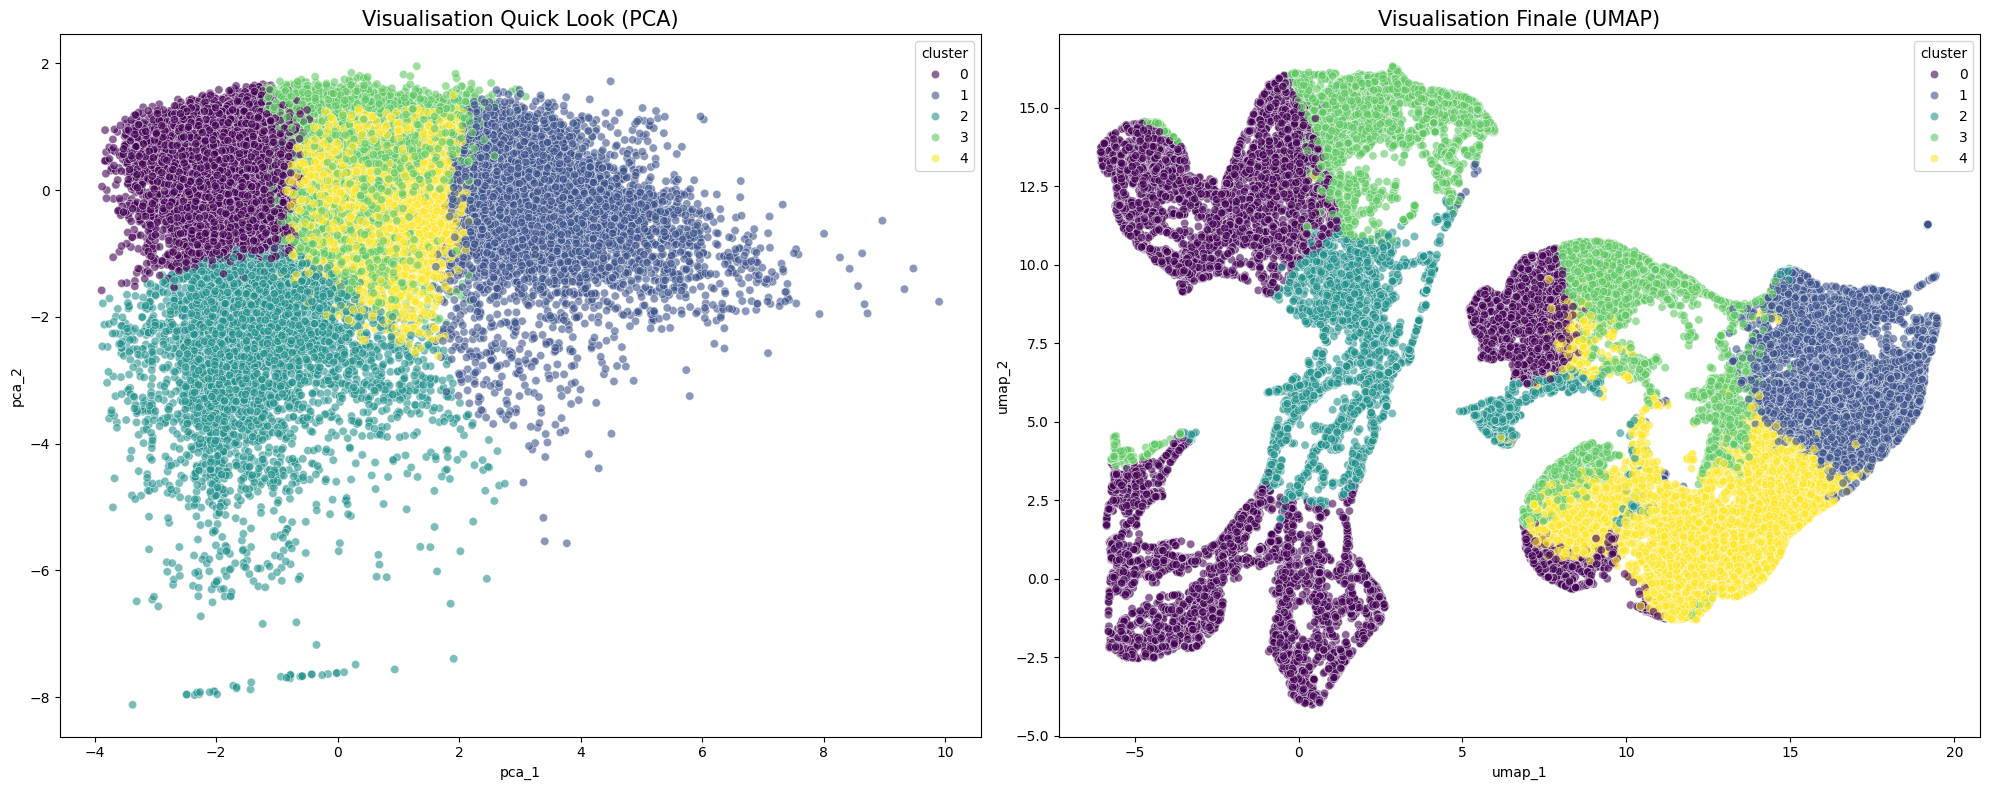

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import umap.umap_ as umap

# 1. Configuration de la PCA (Linéaire, rapide)
pca = PCA(n_components=2)
pca_results = pca.fit_transform(df_scaled)
df_features['pca_1'] = pca_results[:, 0]
df_features['pca_2'] = pca_results[:, 1]

# 2. Configuration d'UMAP (Non-linéaire, plus précis pour les clusters)
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
umap_results = reducer.fit_transform(df_scaled)
df_features['umap_1'] = umap_results[:, 0]
df_features['umap_2'] = umap_results[:, 1]

# 3. Affichage comparatif
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# Plot PCA
sns.scatterplot(data=df_features, x='pca_1', y='pca_2', hue='cluster',
                palette='viridis', alpha=0.6, ax=ax[0])
ax[0].set_title('Visualisation Quick Look (PCA)', fontsize=15)

# Plot UMAP
sns.scatterplot(data=df_features, x='umap_1', y='umap_2', hue='cluster',
                palette='viridis', alpha=0.6, ax=ax[1])
ax[1].set_title('Visualisation Finale (UMAP)', fontsize=15)

plt.tight_layout()
plt.show()

**PCA (Principal Component Analysis) :** Une approche linéaire qui permet d'identifier les axes de variance maximale. Elle offre une vue d'ensemble rapide de la dispersion globale.

**UMAP (Uniform Manifold Approximation and Projection) :** Une technique non-linéaire plus avancée qui préserve les structures locales. Elle est idéale pour valider visuellement la qualité du clustering en montrant des groupes distincts ("îles") si les segments sont cohérents.

**5.2 Profil Démographique (Pays et Ancienneté)**

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/tmp/ipython-input-494/2426135966.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_customers, x='cluster', y='tenure_days', palette='viridis')


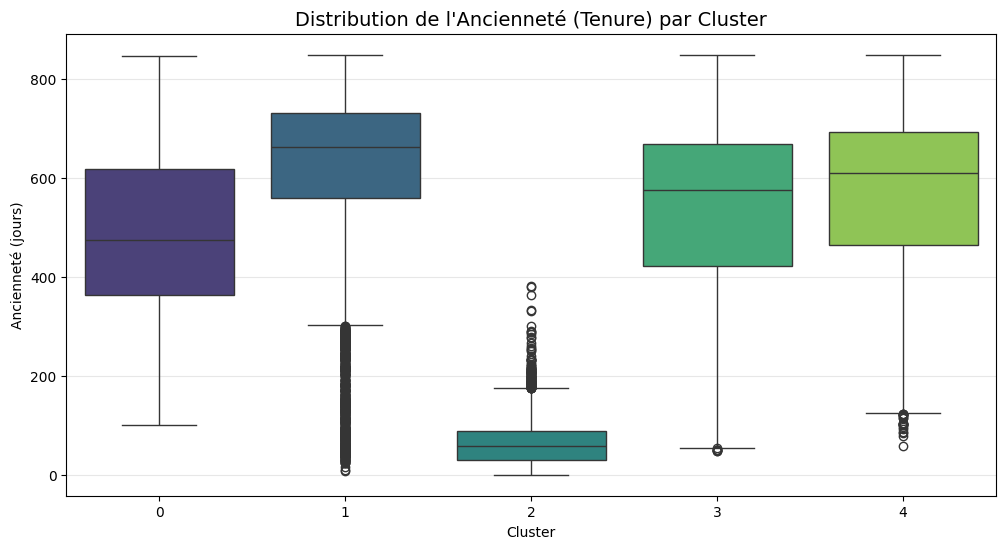

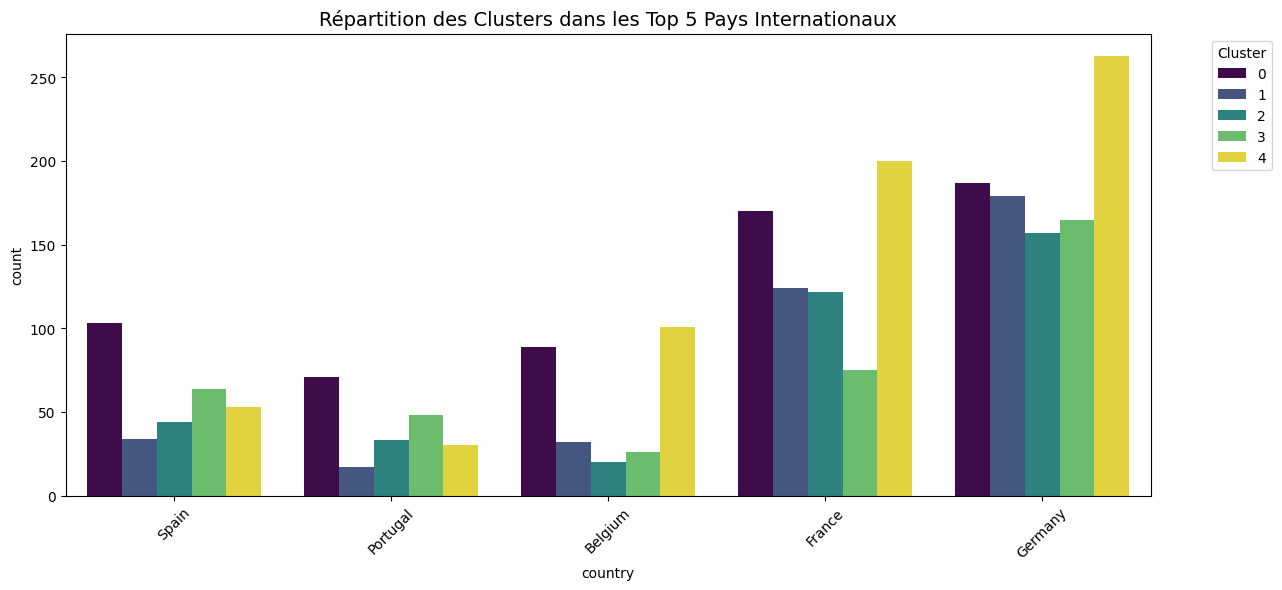

Profil Démographique Moyen par Cluster :


,Ancienneté Moyenne,% Clients UK
cluster,,
0,481.1,93.2
1,615.1,92.4
2,65.2,88.6
3,538.6,88.1
4,570.3,90.2


In [ ]:
# Configuration du clustering final avec 5 clusters
k_final = 5
kmeans_final = KMeans(n_clusters=k_final, init='k-means++', random_state=42, n_init=10)
df_features['cluster'] = kmeans_final.fit_predict(df_scaled)

# Calcul des coordonnées PCA pour une visualisation linéaire des groupes
pca = PCA(n_components=2)
pca_results = pca.fit_transform(df_scaled)
df_features['pca_1'] = pca_results[:, 0]
df_features['pca_2'] = pca_results[:, 1]

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
umap_results = reducer.fit_transform(df_scaled)
df_features['umap_1'] = umap_results[:, 0]
df_features['umap_2'] = umap_results[:, 1]

# Création du dataframe df_customers par fusion avec les données démographiques
df_customers = df_features.copy()
df_customers = df_customers.reset_index().merge(df_cust[['customer_id', 'country']], on='customer_id', how='left')
df_customers.set_index('customer_id', inplace=True)

# Création d'une variable binaire pour distinguer le marché UK du marché International
df_customers['is_uk'] = df_customers['country'].apply(lambda x: 'United Kingdom' if x == 'United Kingdom' else 'Other')

# --- 1. Analyse de l'Ancienneté (Tenure) ---
# Visualisation de la répartition de l'ancienneté pour identifier les segments historiques vs nouveaux
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_customers, x='cluster', y='tenure_days', palette='viridis')
plt.title('Distribution de l\'Ancienneté (Tenure) par Cluster', fontsize=14)
plt.ylabel('Ancienneté (jours)')
plt.xlabel('Cluster')
plt.grid(axis='y', alpha=0.3)
plt.show()

# --- 2. Analyse Géographique (Top Pays hors UK) ---
# Analyse de la présence des clusters dans les principaux marchés à l'export
top_intl_countries = df_customers[df_customers['country'] != 'United Kingdom']['country'].value_counts().nlargest(5).index
df_intl = df_customers[df_customers['country'].isin(top_intl_countries)]

plt.figure(figsize=(14, 6))
sns.countplot(data=df_intl, x='country', hue='cluster', palette='viridis')
plt.title('Répartition des Clusters dans les Top 5 Pays Internationaux', fontsize=14)
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.show()

# --- 3. Tableau récapitulatif ---
demo_profile = df_customers.groupby('cluster').agg({
    'tenure_days': 'mean',
    'is_uk': lambda x: (x == 'United Kingdom').mean() * 100
}).rename(columns={'tenure_days': 'Ancienneté Moyenne', 'is_uk': '% Clients UK'})

print("Profil Démographique Moyen par Cluster :")
display(demo_profile.round(1))

**Distribution de l'Ancienneté (Tenure) :** À l'aide de boxplots, nous analysons si les segments sont composés de clients historiques (vétérans) ou de nouveaux clients récemment acquis.

**Répartition Géographique :** Le marché étant dominé par le Royaume-Uni (UK), nous isolons les marchés internationaux pour vérifier si certains segments  sont spécifiquement liés à l'export. Cela permet d'adapter les futures stratégies logistiques et de frais de port.

**5.3 Scatter Plot : Récence vs Montant**

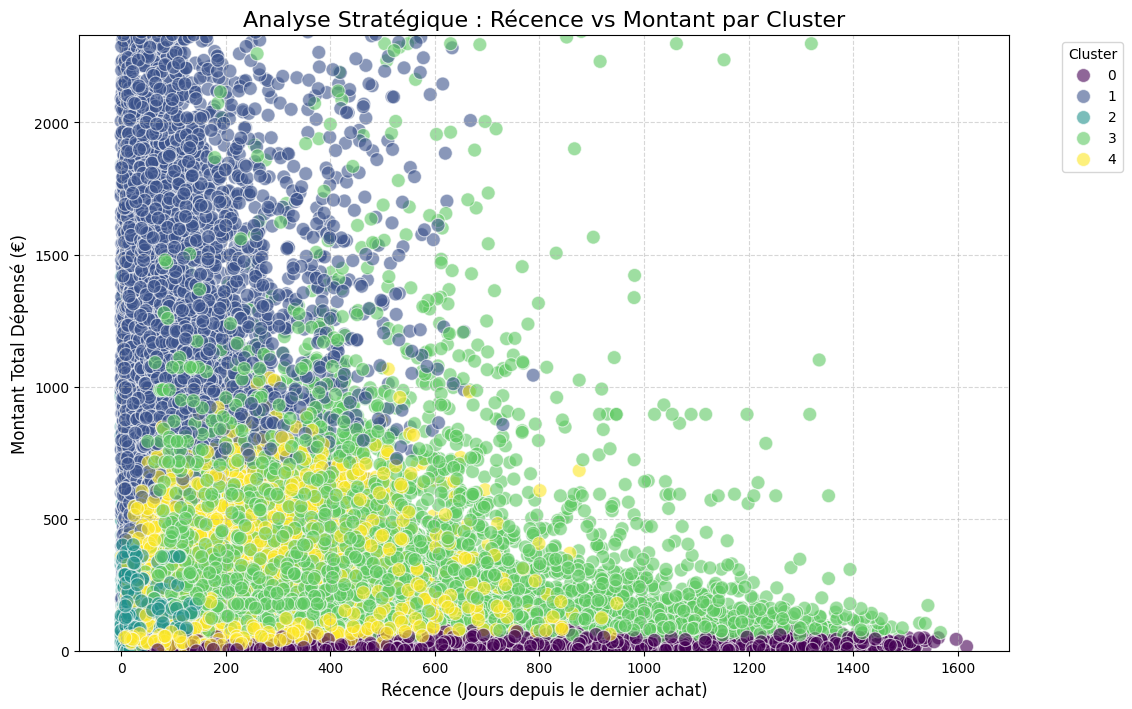

In [ ]:
plt.figure(figsize=(12, 8))

sns.scatterplot(
    data=df_customers,
    x='recency',
    y='monetary',
    hue='cluster',
    palette='viridis',
    s=100,
    alpha=0.6,
    edgecolor='w'
)

# Ajustement des axes pour une meilleure lisibilité

plt.ylim(0, df_customers['monetary'].quantile(0.95))

plt.title('Analyse Stratégique : Récence vs Montant par Cluster', fontsize=16)
plt.xlabel('Récence (Jours depuis le dernier achat)', fontsize=12)
plt.ylabel('Montant Total Dépensé (€)', fontsize=12)
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

Ce graphique permet de visualiser la valeur des clients par rapport à leur date de dernier achat.

**Ce qu'il faut retenir :**

**Axe vertical (Montant) :** Plus un point est haut, plus le client est rentable.

**Axe horizontal (Récence) :** Plus un point est à gauche, plus le client est actif.

**Clusters :** La séparation des couleurs montre que l'algorithme a bien regroupé les clients par "niveaux" de valeur et d'activité.

**5.4 Heatmap des features moyennes par cluster**

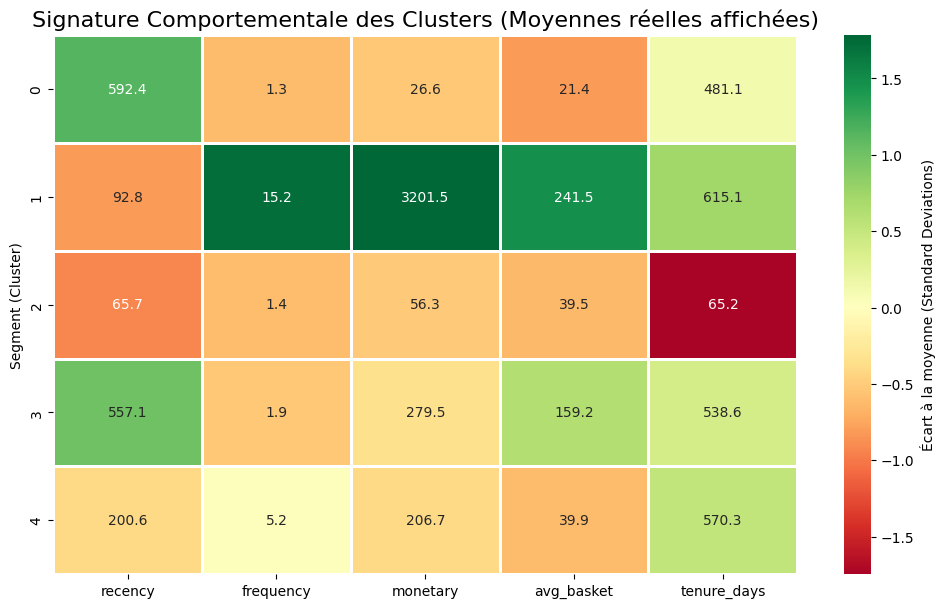

In [ ]:
# 1. Sélection des indicateurs avec les noms de colonnes identifiés dans le dataframe
features = ['recency', 'frequency', 'monetary', 'avg_basket', 'tenure_days']

# 2. Calcul des moyennes par cluster
cluster_profile = df_customers.groupby('cluster')[features].mean()

# 3. Normalisation (Z-score) pour une comparaison visuelle cohérente
cluster_averages_norm = (cluster_profile - cluster_profile.mean()) / cluster_profile.std()

# 4. Génération de la Heatmap
plt.figure(figsize=(12, 7))
sns.heatmap(
    cluster_averages_norm,
    annot=cluster_profile,
    fmt=".1f",
    cmap="RdYlGn",
    center=0,
    linewidths=1,
    cbar_kws={'label': 'Écart à la moyenne (Standard Deviations)'}
)

plt.title('Signature Comportementale des Clusters (Moyennes réelles affichées)', fontsize=16)
plt.ylabel('Segment (Cluster)')
plt.show()

Cette heatmap est le bilan final du profilage. Elle permet de comparer les clusters entre eux en affichant leurs moyennes réelles tout en utilisant des couleurs pour souligner les écarts à la moyenne globale.

**Points clés à retenir :**

**Les Couleurs :** Le **Vert** indique une valeur supérieure à la moyenne, le **Rouge** une valeur inférieure.

**La Récence :** Un chiffre **faible** (rouge) est positif car il signifie que le client est revenu récemment.

**Utilité :** Ce tableau permet de donner un "nom" marketing à chaque groupe.